A partir del archivo Euro_2012_stats_TEAM, se pide:

1. Obtener la matriz de correlación. ¿Qué columnas están mejor correlacionadas?

2. ¿Existe algún tipo de relación entre la precisión de disparo a puerta (Shooting Accuracy) con respecto a los goles? Muestra en una gráfica (pintando la línea en la distribución de ambas variables) y usando Regresión Lineal, Regresión no Lineal con polinomio y SVR la relación entre ambos. Por cada porcentaje de acierto de cara a puerta, ¿cuánto aumenta o disminuye el número de goles? 

3. Si tratamos la columna Goals como una columna categórica y usando logistic regression, SVM y Random forest, ¿cuántos goles marcaría un equipo que tiene...? (por cada algoritmo):

    - % de goles por disparo: 40%
    - Total shots (inc. Blocked): 102
    - Corners Taken: 5
    - Passes: 82
    - Dribbles: 23

## First, import the necessary libraries

In [1]:
# ----------------
import pandas as pd 
import numpy as np 
#-----------------
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
#-----------------
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/Euro_2012_stats_TEAM.csv")
df

,Team,Goals,Shots on target,Shots off target,Shooting Accuracy,% Goals-to-shots,Total shots (inc. Blocked),Hit Woodwork,Penalty goals,Penalties not scored,...,Saves made,Saves-to-shots ratio,Fouls Won,Fouls Conceded,Offsides,Yellow Cards,Red Cards,Subs on,Subs off,Players Used
0,Croatia,4,13,12,51.9%,16.0%,32,0,0,0,...,13,81.3%,41,62,2,9,0,9,9,16
1,Czech Republic,4,13,18,41.9%,12.9%,39,0,0,0,...,9,60.1%,53,73,8,7,0,11,11,19
2,Denmark,4,10,10,50.0%,20.0%,27,1,0,0,...,10,66.7%,25,38,8,4,0,7,7,15
3,England,5,11,18,50.0%,17.2%,40,0,0,0,...,22,88.1%,43,45,6,5,0,11,11,16
4,France,3,22,24,37.9%,6.5%,65,1,0,0,...,6,54.6%,36,51,5,6,0,11,11,19
5,Germany,10,32,32,47.8%,15.6%,80,2,1,0,...,10,62.6%,63,49,12,4,0,15,15,17
6,Greece,5,8,18,30.7%,19.2%,32,1,1,1,...,13,65.1%,67,48,12,9,1,12,12,20
7,Italy,6,34,45,43.0%,7.5%,110,2,0,0,...,20,74.1%,101,89,16,16,0,18,18,19
8,Netherlands,2,12,36,25.0%,4.1%,60,2,0,0,...,12,70.6%,35,30,3,5,0,7,7,15
9,Poland,2,15,23,39.4%,5.2%,48,0,0,0,...,6,66.7%,48,56,3,7,1,7,7,17


In [3]:
from data_mining_tb import df_info
df_info(df=df)

####
DATAFRAME INFO
####

Number of rows: 16
Number of columns: 35

#### DATAFRAME COLUMNS ####
 Index(['Team', 'Goals', 'Shots on target', 'Shots off target',
       'Shooting Accuracy', '% Goals-to-shots', 'Total shots (inc. Blocked)',
       'Hit Woodwork', 'Penalty goals', 'Penalties not scored', 'Headed goals',
       'Passes', 'Passes completed', 'Passing Accuracy', 'Touches', 'Crosses',
       'Dribbles', 'Corners Taken', 'Tackles', 'Clearances', 'Interceptions',
       'Clearances off line', 'Clean Sheets', 'Blocks', 'Goals conceded',
       'Saves made', 'Saves-to-shots ratio', 'Fouls Won', 'Fouls Conceded',
       'Offsides', 'Yellow Cards', 'Red Cards', 'Subs on', 'Subs off',
       'Players Used'],
      dtype='object') 

### DATAFRAME COLUMN TYPES ###

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Te

### Some of the columns are objects in spite of having numerical data.
    - In order to change their type, we should make some adjustments

In [4]:
#Rename a specific column in order to avoid misleading strings
df.rename(columns={'% Goals-to-shots': 'Goals-to-shots-percentage'}, inplace=True)
col_list = ['Shooting Accuracy', 'Goals-to-shots-percentage', 'Passing Accuracy', 'Saves-to-shots ratio']

### Define a function to remove percentages from specific columns


In [5]:
def remove_df_percentage(df, columns_list):
    '''
    @leosanchezsoler
    Strips percentage symbols in order to rearrange the data type
       
        Parameters:
            - df: a pandas.DataFrane
            - columns_list: a list with the columns of the DataFrame that will be changed

        Returns:
            The dataframe with new column types
    '''
    for pos, i in enumerate(df[columns_list]):
        df[columns_list[pos]] = df[columns_list[pos]].str.rstrip('%').astype('float') / 100.00
    
    return f'The following columns have been changed: {columns_list}'
    
remove_df_percentage(df=df, columns_list=col_list)

"The following columns have been changed: ['Shooting Accuracy', 'Goals-to-shots-percentage', 'Passing Accuracy', 'Saves-to-shots ratio']"

### Check if the change was made

In [6]:
df_info(df=df)

####
DATAFRAME INFO
####

Number of rows: 16
Number of columns: 35

#### DATAFRAME COLUMNS ####
 Index(['Team', 'Goals', 'Shots on target', 'Shots off target',
       'Shooting Accuracy', 'Goals-to-shots-percentage',
       'Total shots (inc. Blocked)', 'Hit Woodwork', 'Penalty goals',
       'Penalties not scored', 'Headed goals', 'Passes', 'Passes completed',
       'Passing Accuracy', 'Touches', 'Crosses', 'Dribbles', 'Corners Taken',
       'Tackles', 'Clearances', 'Interceptions', 'Clearances off line',
       'Clean Sheets', 'Blocks', 'Goals conceded', 'Saves made',
       'Saves-to-shots ratio', 'Fouls Won', 'Fouls Conceded', 'Offsides',
       'Yellow Cards', 'Red Cards', 'Subs on', 'Subs off', 'Players Used'],
      dtype='object') 

### DATAFRAME COLUMN TYPES ###

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  ----- 

## Use pairplot to show the relation between columns

### Draw the correlation matrix

<AxesSubplot:>

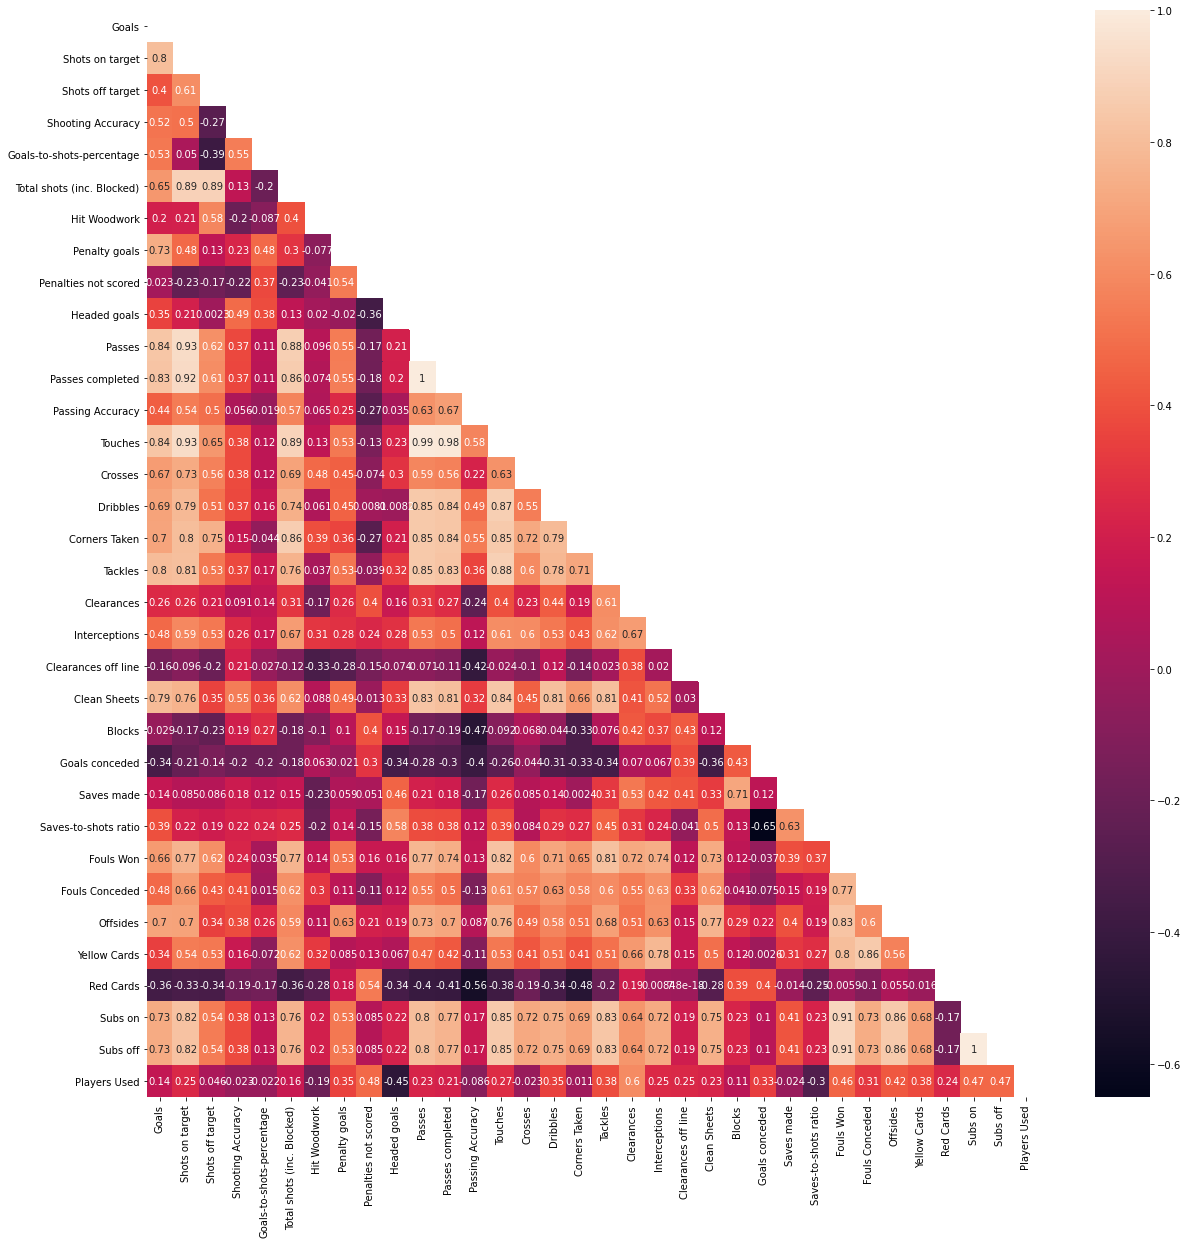

In [7]:
corr = df.corr()
matrix = np.triu(df.corr())

f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(data=corr, annot=True, xticklabels=1, yticklabels=1, mask=matrix)

### Now, let's see if there's any kind of relationship between the Shooting Accuracy and goals
- Define `X` and `y`

In [8]:
# X --> Feature
X = np.array(df['Shooting Accuracy']).reshape(-1, 1)

# y --> Target
y = np.array(df['Goals'])

### Split the data

In [27]:
# Use train_test_split
test_size = 0.2
seed = 197

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Import a function to check shapes

from machine_learning_tb import check_train_test_shape
check_train_test_shape(X, y, X_train, y_train, X_test, y_test)

#### AVAILABLE DATA ####

X: (16, 1)
y: (16,)

#### TRAIN SETS ####

X_train: (12, 1)
y_train: (12,)

#### TEST SETS ####

X_test: (4, 1)
y_test: (4,)


### Prepare the necessary configuration to display which model fits better with the data

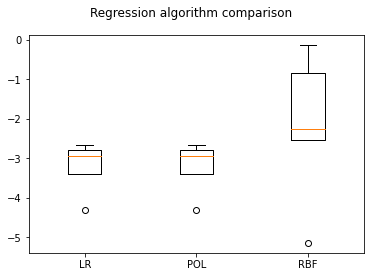

In [28]:
# Prepare models
models = []

models.append(('LR', LinearRegression()))
models.append(('POL', LinearRegression()))
models.append(('RBF', SVR(kernel = 'rbf')))

# Evaluate the model in each iteration
# Create 2 empty lists
results = []
model_name = []

#The neg_mean_absolute_error will display in a boxplot the best model for predicting
score = 'neg_mean_absolute_error'

for name, model in models:
    kfold = KFold(n_splits=5, random_state=6, shuffle=True)
    if name == 'POL':
        poly_reg = PolynomialFeatures(degree=4)
        X_poly = poly_reg.fit_transform(X_train)
        cv_results = cross_val_score(model, X_train, y_train.ravel(), cv=kfold, scoring=score)
   
    else:
        cv_results = cross_val_score(model, X_train, y_train.ravel(), cv=kfold, scoring=score)

    results.append(cv_results)
    model_name.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())

# Plot algorithm comparison
fig = plt.figure()
fig.suptitle('Regression algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(model_name)
plt.show()

### As we can see above, it is clear that the RBF is the best model for this case. 

### Now, let's draw graphs to show how they perform.



In [1]:
# First, assign variables to every model with its parameters

# svr_rbf, svr_lin, svr_poly
svr_rbf = SVR(kernel='rbf', C=100, gamma='auto')
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=200, gamma='auto', degree=3)

# Look at the results
svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['r', 'b', 'g']

#Create a RMSE list to track the metrics for each model:
rmse_list = []

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 15), sharey=True)
for ix, svr in enumerate(svrs):
    model = svr.fit(X, y)
    y_prediction = model.predict(X)
    rmse = np.sqrt(metrics.mean_squared_error(y_prediction, y))
    rmse_list.append(rmse)
    axes[ix].plot(X, y_prediction, color=model_color[ix], label='{} model'.format(kernel_label[ix]))
    axes[ix].scatter(X[svr.support_], y[svr.support_], facecolor='none', edgecolor="k", s=50,
                     label='other training data')
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'Shooting accuracy', ha='center', va='center')
fig.text(0.06, 0.5, 'Goals', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

NameError: name 'SVR' is not defined

In [30]:
rmse_list = dict(zip(kernel_label, rmse_list))
rmse_list

NameError: name 'kernel_label' is not defined

## At first sight, we can conclude that all three models don't seem to have significant error's difference.


## Now let's try doing the same thing but treating `Goals` column as a categorical feature
- For this model we have to reassign both the Features(`X`) and the target(`y`)

In [40]:
df

,Team,Goals,Shots on target,Shots off target,Shooting Accuracy,Goals-to-shots-percentage,Total shots (inc. Blocked),Hit Woodwork,Penalty goals,Penalties not scored,...,Saves made,Saves-to-shots ratio,Fouls Won,Fouls Conceded,Offsides,Yellow Cards,Red Cards,Subs on,Subs off,Players Used
0,Croatia,4,13,12,0.519,0.160,32,0,0,0,...,13,0.813,41,62,2,9,0,9,9,16
1,Czech Republic,4,13,18,0.419,0.129,39,0,0,0,...,9,0.601,53,73,8,7,0,11,11,19
2,Denmark,4,10,10,0.500,0.200,27,1,0,0,...,10,0.667,25,38,8,4,0,7,7,15
3,England,5,11,18,0.500,0.172,40,0,0,0,...,22,0.881,43,45,6,5,0,11,11,16
4,France,3,22,24,0.379,0.065,65,1,0,0,...,6,0.546,36,51,5,6,0,11,11,19
5,Germany,10,32,32,0.478,0.156,80,2,1,0,...,10,0.626,63,49,12,4,0,15,15,17
6,Greece,5,8,18,0.307,0.192,32,1,1,1,...,13,0.651,67,48,12,9,1,12,12,20
7,Italy,6,34,45,0.430,0.075,110,2,0,0,...,20,0.741,101,89,16,16,0,18,18,19
8,Netherlands,2,12,36,0.250,0.041,60,2,0,0,...,12,0.706,35,30,3,5,0,7,7,15
9,Poland,2,15,23,0.394,0.052,48,0,0,0,...,6,0.667,48,56,3,7,1,7,7,17


In [9]:
# X --> Features
X = df[['Goals-to-shots-percentage', 'Total shots (inc. Blocked)', 'Corners Taken', 'Passes', 'Dribbles']]

# y --> Target
y = df['Goals']

#### Split the data

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

check_train_test_shape(X=X, y=y, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

#### AVAILABLE DATA ####

X: (16, 5)
y: (16,)

#### TRAIN SETS ####

X_train: (12, 5)
y_train: (12,)

#### TEST SETS ####

X_test: (4, 5)
y_test: (4,)


3. Si tratamos la columna Goals como una columna categórica y usando logistic regression, SVM y Random forest, ¿cuántos goles marcaría un equipo que tiene...? (por cada algoritmo):

    - % de goles por disparo: 40%
    - Total shots (inc. Blocked): 102
    - Corners Taken: 5
    - Passes: 82
    - Dribbles: 23

In [24]:
value_to_predict = {'Goals-to-shot-percentages': [0.4], 'Total shots (inc. Blocked)': [102], 'Corners Taken': [5], 'Passes': [82], 'Dribbles': [23]}
value_to_predict

X_new = pd.DataFrame.from_dict(value_to_predict)

X_new = np.array(X_new)
X_new

array([[  0.4, 102. ,   5. ,  82. ,  23. ]])

In [25]:
# Prepare a for loop to iterate through the data using different models

# SVC models
C = 100
gamma = 10
svc_rbf = SVC(kernel='rbf', C=C, gamma=gamma)
svc_lin = SVC(kernel='linear', C=C)

# LogisticRegression
log_reg = LogisticRegression(n_jobs=-1)

# RandomForest Classifier
rfc = RandomForestClassifier(n_estimators=1000, verbose=0, n_jobs=5)

#Create a list with all the models
models_list = [svc_rbf, svc_lin, log_reg, rfc]

model_name = []
model_rmse = []
model_score = []
accuracy_score = []
r2_list = []

# Create a for loop
for pos, model in enumerate(models_list):
    model.fit(X, y)
    y_pred = model.predict(X_new)
    print(f'Goals predicted with {model}', y_pred)
    #accuracy = metrics.accuracy_score(y_test, y_pred)
    score = model.score(X, y)
    print('Model score:', score)
    #model_name.append(str(model))
    model_score.append(score)
    #accuracy_score.append(accuracy)
    model_score.append(score)

Goals predicted: [5]
Model score: 1.0
Goals predicted: [1]
Model score: 1.0
Goals predicted: [6]
Model score: 0.75
Goals predicted: [5]
Model score: 1.0


### Conclusion
- Here we can see that the dataset is not big enough to be splitted.